In [75]:
import neuron as neuron

from dataProcessing import getData, getFilename, calculateLatency, calculateVelocity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stimulationProtocols import getCOVIDFullTime
from plot import plotLatency, plotRecoveryCycle, getLatency
import os
from main import run


neuron.load_mechanisms('./MOD_Tigerholm')

True

In [53]:
gPump = -0.0047891
gNav17 = 0.10664
gNav18 = 0.24271
gNav19 = 9.4779e-05
gKs = 0.0069733
gKf = 0.012756
gH = 0.0025377
gKdr = 0.018002
gKna = 0.00042
vRest = -55

param_orig = np.array([
    gPump,
    gNav17,
    gNav18,
    gNav19,
    gKs,
    gKf,
    gH,
    gKdr,
    gKna
])
# -0.5 too less. Might need to increase to finer ones. Also faster is probably higher conductance, intuitively?? But for all channels?
changes = [-0.2, -0.18, -0.15, -0.1, -0.05, -0.03, 0.0, 0.03, 0.05, 0.1, 0.15, 0.18, 0.2, 0.25]
param_names = ['gPump', 'gNav17', 'gNav18', 'gNav19', 'gKs', 'gKf', 'gH', 'gKdr', 'gKna']
params = {}
spikes = {}

for name in param_names:
    params[name] = {}
    spikes[name] = {}
for i, x in enumerate(param_orig):
    for dg in changes:
        param_new = param_orig.copy()
        param_new[i] = param_orig[i] * (1 + dg) # scale 1 parameter

        params[param_names[i]][dg] = param_new

In [54]:
protocol = 42

In [55]:
for name in param_names:
    for j, dg in enumerate(changes):
        param = params[name][dg]
        spike = getData(prot=protocol, filetype="spikes", scalingFactor=0.1, gPump=param[0], gNav17=param[1], gNav18=param[2], gNav19=param[3], gKs=param[4], gKf=param[5], gH=param[6], gKdr=param[7], gKna=param[8])
        spikes[name][dg] = spike

In [56]:
data_stim = getData(prot=protocol, filetype="stim")

In [57]:
#plotRecoveryCycle(spikes, data_stim)
print(len(spikes), len(data_stim))

9 496


In [59]:
latencies = np.zeros((len(param_orig),len(changes), len(data_stim)))
latencies_percent = np.zeros((len(param_orig),len(changes), len(data_stim)))
for i, name in enumerate(param_names):
    for j, dg in enumerate(changes):
        latencies[i][j] = calculateLatency(spikes[name][dg], data_stim, norm=False) # ms and not ADS %
        latencies_percent[i][j] = calculateLatency(spikes[name][dg], data_stim, norm=True) # ADS % and not ms

In [61]:
initial_velocities = np.zeros((len(param_orig),len(changes)))
for i, name in enumerate(param_names):
    for j, dg in enumerate(changes):
        v = calculateVelocity(spikes[name][dg], data_stim)
        initial_velocities[i][j] = v[1]

In [62]:
def get_metrics(data_aps, data_stim, Slow025HzStart=1, Slow025HzEnd=90, Fast2HzStart=90, Fast2HzEnd=450, Fast2HzPost30S=458):
    initial_velocity = calculateVelocity(data_aps, data_stim)[0]
    latency = calculateLatency(spikes[name][dg], data_stim, norm=False)
    latency_points = [latency[Slow025HzStart], latency[Fast2HzStart], latency[Fast2HzEnd], latency[Fast2HzPost30S]]
    Slow025StartToEnd = (latency[Slow025HzEnd] - latency[Slow025HzStart]) / latency[Slow025HzStart]
    Slow025EndToFast2HzEnd = (latency[Fast2HzEnd] - latency[Slow025HzEnd]) / latency[Slow025HzEnd]
    # recovery at 30 s (latency at 30 s after 2 Hz stimulation compared to latency before 0.25 Hz stimulation)
    # can be also negative (but unlikely)
    Fast2HzStartToPost30S = (latency[Fast2HzPost30S] - latency[Slow025HzStart]) / latency[Slow025HzStart]
    TimeTo50Percent = 0 # not implemented yet because it is barely changed by the conductancies
    return (initial_velocity, Slow025StartToEnd, Slow025EndToFast2HzEnd, Fast2HzStartToPost30S, TimeTo50Percent, latency_points)

In [63]:
Slow025HzStart = 1
Slow025HzEnd = 90
Fast2HzStart = 90 # 90 stimulations at 0.25 Hz initially
Fast2HzEnd = 450 # 360 stimulations at 2 Hz
Fast2HzPost30S = Fast2HzEnd + 8 # 32 s after reducing the stimulation frequency from 2 Hz to 0.25 Hz again
# last one is the end of simulation
SimulationEnd = latencies.shape[2] - 1
points = [Slow025HzStart, Slow025HzEnd, Fast2HzStart, Fast2HzEnd, Fast2HzPost30S, SimulationEnd]
points_name = ["InitialVelocity", "Slow025HzStart", "Slow025HzEnd", "Fast2HzStart", "Fast2HzEnd", "Fast2HzPost30S", "SimulationEnd"]
slowing_name = [points_name[0], points_name[1]+"-"+points_name[2], points_name[3]+"-"+points_name[4], points_name[5], "TimeTo50Percent"]

latencies_at_points = np.zeros((len(param_orig), len(changes), 6)) # at special points
slowing_abs = np.zeros((len(param_orig),len(changes), 5)) # Slowing 0 to 0.25, 0.25 to 2, recovery at 30 s, Time to 50% recovery

# as dicts
latency_dict = {}
slowing_dict = {}

for i, name in enumerate(param_names):
    latency_dict[name] = {}
    slowing_dict[name] = {}
    for j, dg in enumerate(changes):
        latency_dict[name][dg] = {}
        slowing_dict[name][dg] = {}
        for k, (point, point_name) in enumerate(zip(points, points_name)):
            latencies_at_points[i][j][k] = latencies[i][j][point]
            latency_dict[name][dg][point_name] = latencies[i][j][point]
            
        metric = get_metrics(spikes[name][dg], data_stim)
        # Initial velocity
        slowing_abs[i][j][0:4] = metric[0:4]
        slowing_dict[name][dg][slowing_name[0]] = slowing_abs[i][j][0]
        slowing_dict[name][dg][slowing_name[1]] = slowing_abs[i][j][1]
        slowing_dict[name][dg][slowing_name[2]] = slowing_abs[i][j][2]
        slowing_dict[name][dg][slowing_name[3]] = slowing_abs[i][j][3]

        recovery_50_percent_threshold = (latencies[i][j][Fast2HzStart] + latencies[i][j][Fast2HzEnd]) / 2
        # time to 50 % recovery
        for n in np.arange(Fast2HzEnd, SimulationEnd):
            # if the latency at number t-th spike is lower than the 50 % recovery threshold
            if latencies[i][j][n] < recovery_50_percent_threshold:
                # use the time as the time until 50 % recovery
                slowing_abs[i][j][4] = getCOVIDFullTime(n) - getCOVIDFullTime(Fast2HzStart) # can be made more precise with linear interpolation
                slowing_dict[name][dg][slowing_name[4]] = slowing_abs[i][j][4]
                break


In [64]:
getCOVIDFullTime(90)

360010

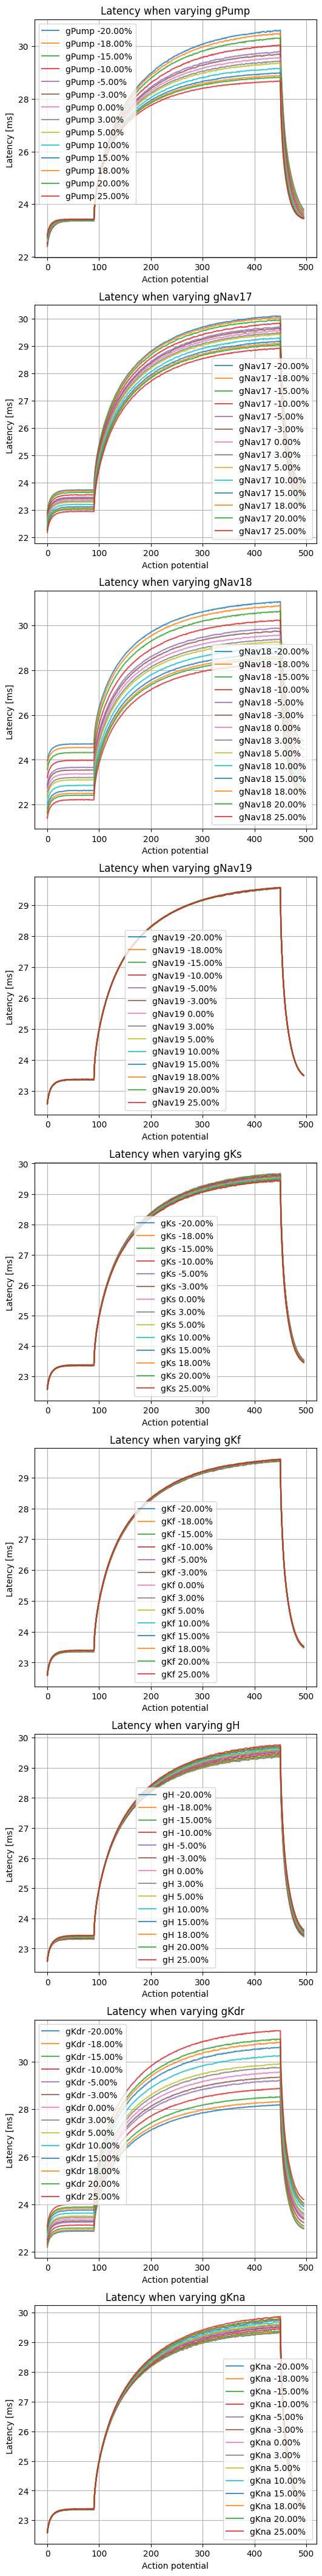

In [65]:
# Plot raw latencies
fig, axes = plt.subplots(len(param_names), 1, figsize=(6, 6*len(param_names)))
for i, name_g in enumerate(param_names):
    ax = axes[i]
    latency = latencies[i]
    for j, latency in enumerate(latency):
        ax.plot(latency, alpha=0.8, label=f"{name_g} {changes[j]*100:.2f}%")

    ax.set_xlabel("Action potential")
    ax.set_ylabel("Latency [ms] ")
    ax.legend()
    ax.grid(True)
    ax.set_title(f"Latency when varying {name_g}")
plt.savefig(f"Results/raw_latency_plot.pdf")

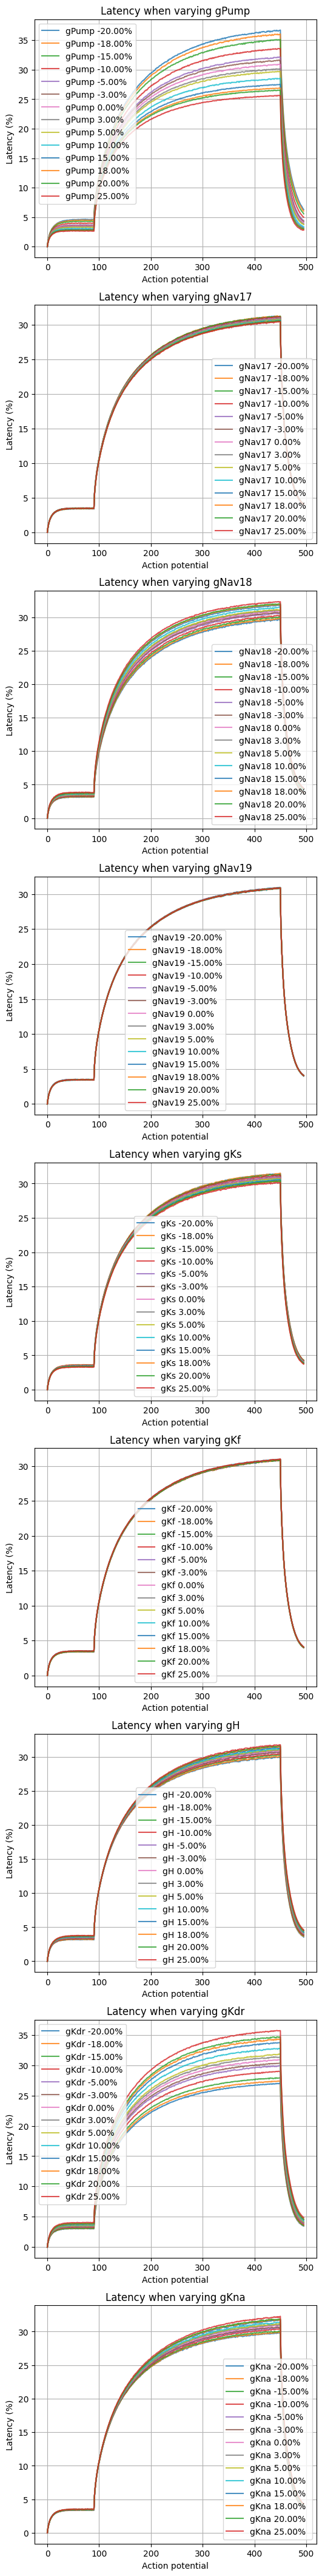

In [66]:
# Plot relative latencies
fig, axes = plt.subplots(len(param_names), 1, figsize=(6, 6*len(param_names)))
for i, name_g in enumerate(param_names):
    ax = axes[i]
    latency = latencies_percent[i]
    for j, latency in enumerate(latency):
        ax.plot(latency, alpha=0.8, label=f"{name_g} {changes[j]*100:.2f}%")

    ax.set_xlabel("Action potential")
    ax.set_ylabel("Latency (%)")
    ax.legend()
    ax.grid(True)
    ax.set_title(f"Latency when varying {name_g}")
plt.savefig(f"Results/raw_ADS_plot.pdf")

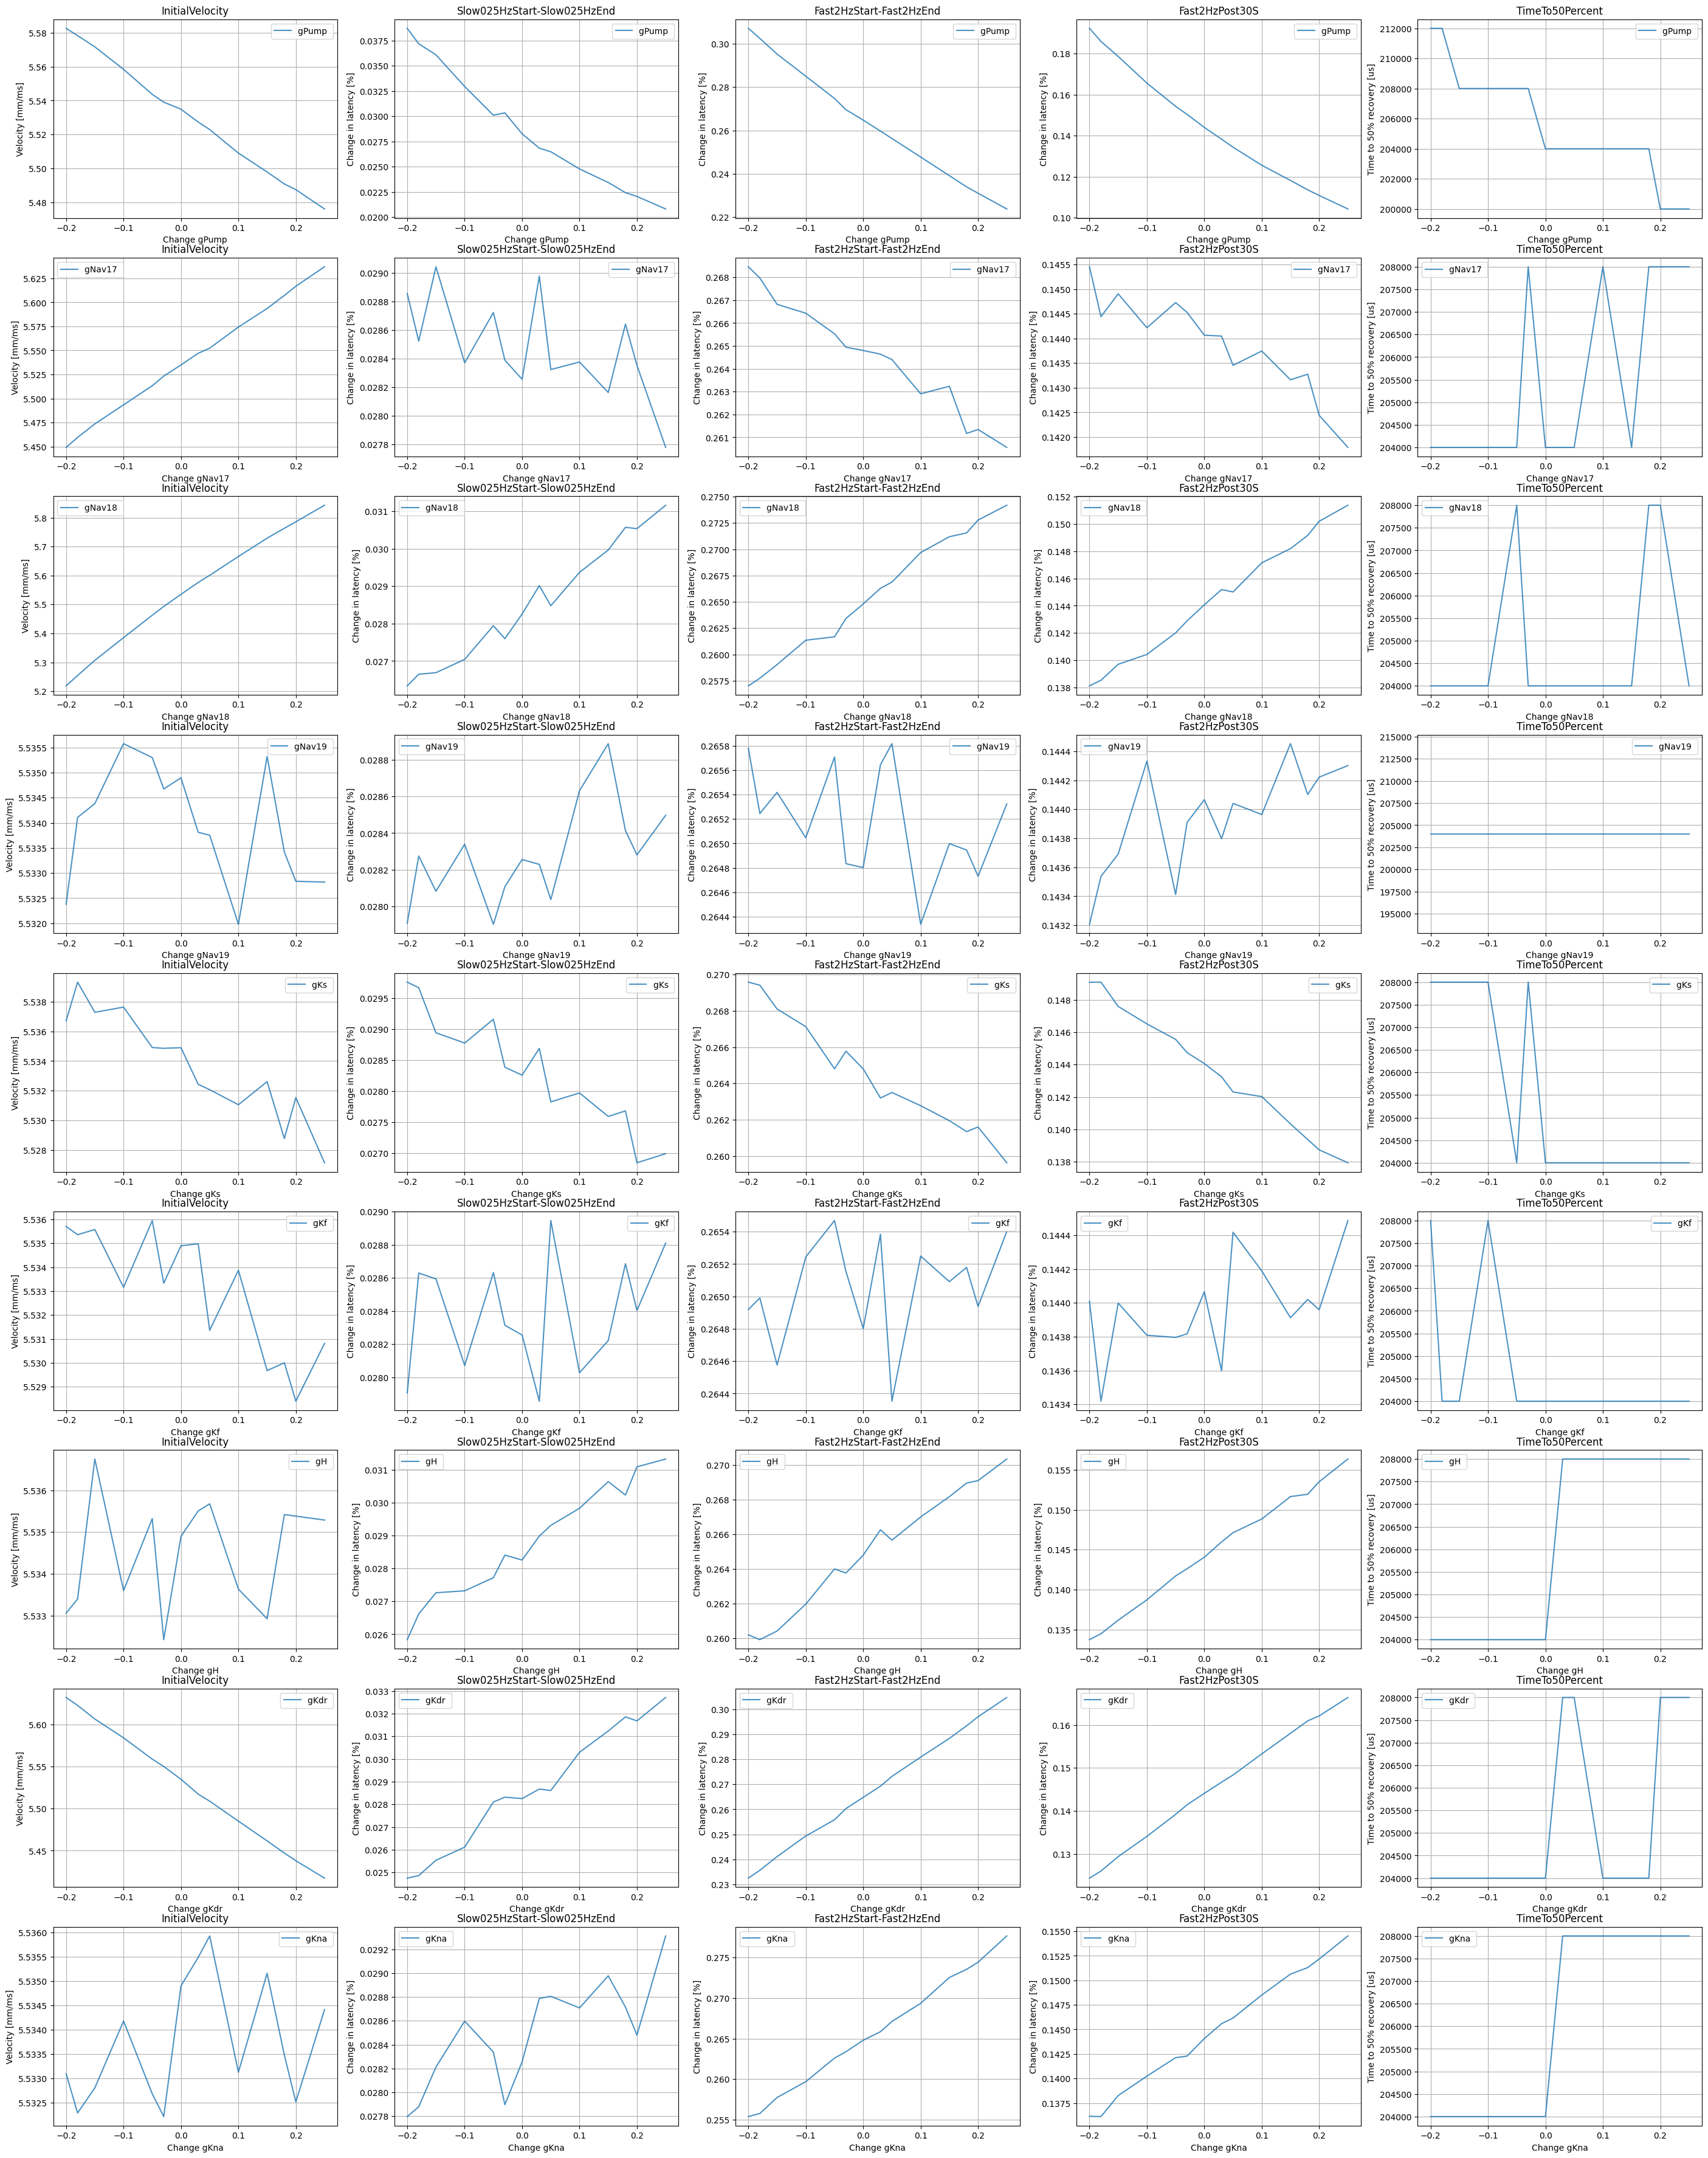

In [67]:
# Plot slowings
fig, axes = plt.subplots(len(param_names), slowing_abs.shape[-1], figsize=(35, 5*len(param_names)))
# Different parameters
for i, name_g in enumerate(param_names):
    slowings = slowing_abs[i]
    # Different changes
    for j in np.arange(slowings.shape[1]):
        axes[i,j].plot(changes, slowings[:, j], alpha=0.8, label=f"{name_g} ")
        #axes[i,j].set_xticks(changes[::3])
        axes[i,j].set_xlabel(f"Change {name_g}")
        axes[i,0].set_ylabel("Velocity [mm/ms]") # IS THIS UNIT MM/MS CORRECT?? see unit of calculateVelocity
        for k in (1, 2, 3):
            axes[i,k].set_ylabel("Change in latency [%]")
        axes[i,4].set_ylabel("Time to 50% recovery [us]")
        axes[i,j].grid(True)
        axes[i,j].legend()
        axes[i, j].set_title(f"{slowing_name[j]}")
plt.savefig(f"Results/relative_slowings_plot.pdf")

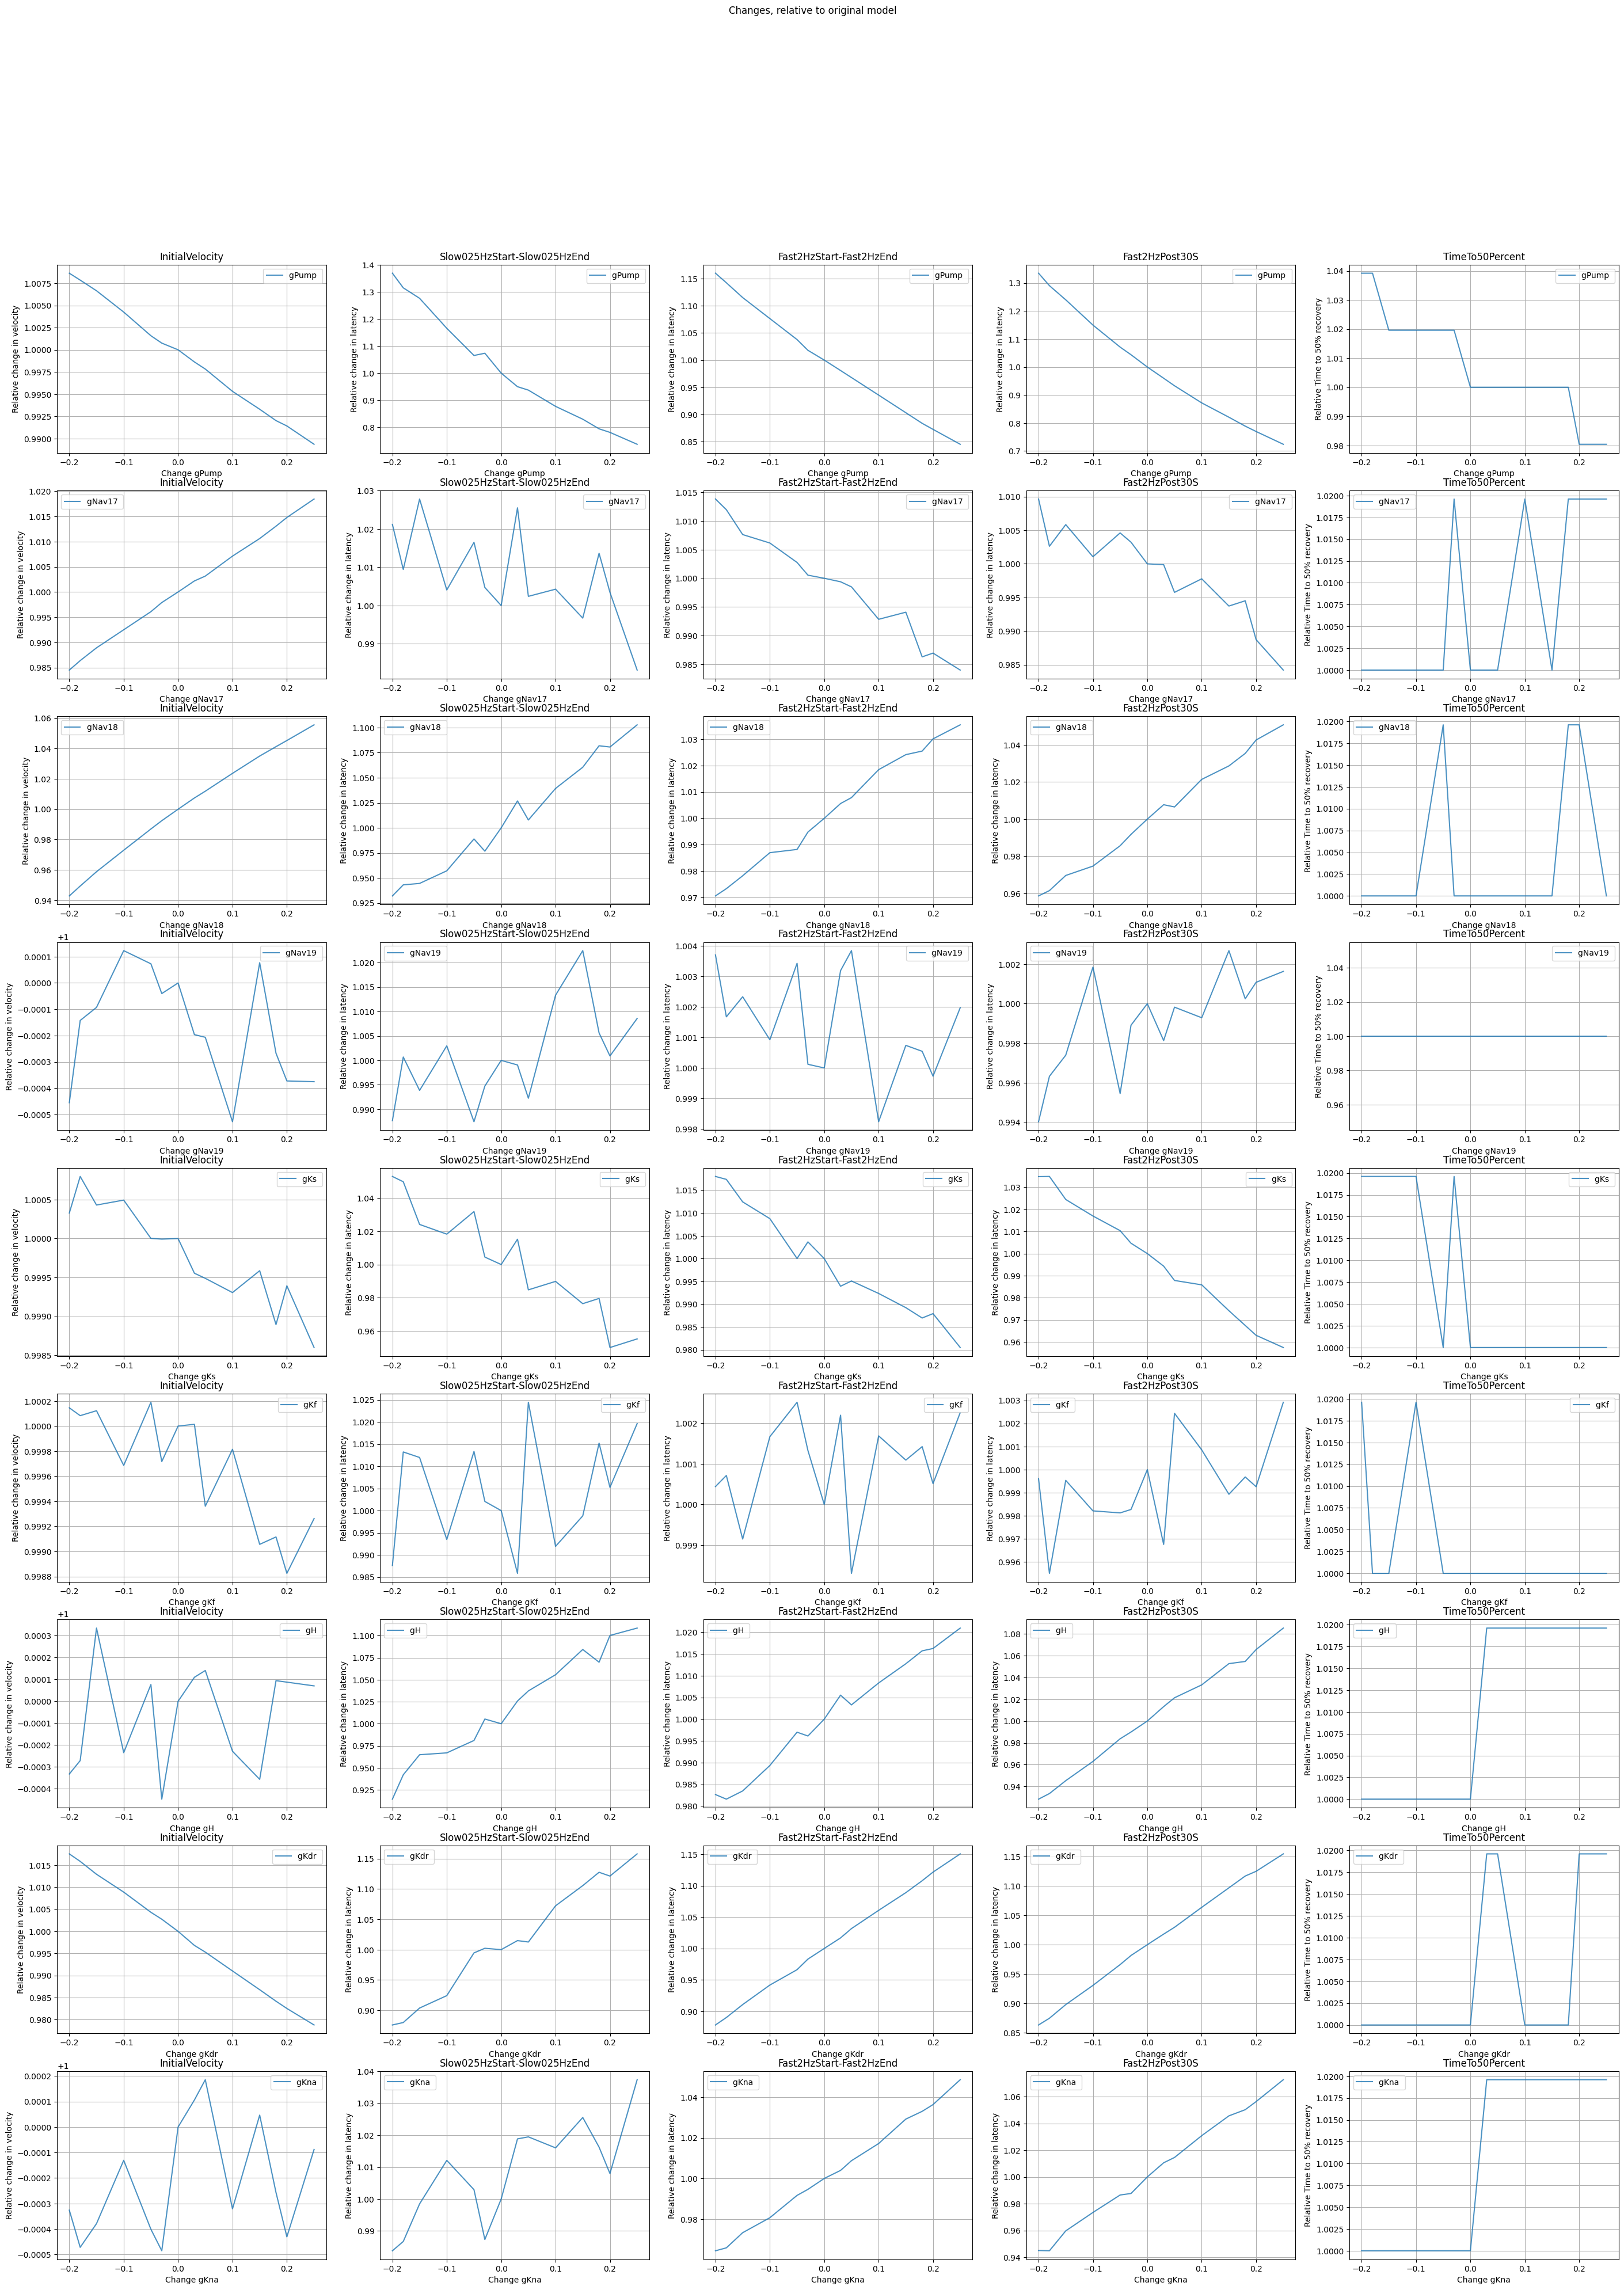

In [68]:
# Plot deviations to "normal" model
i_normal = 6 # where changes = 0

# Normalize slowings to slowing with zero changes to original parameters
normal_value = slowing_abs[:, i_normal, :]
slowing_rel = slowing_abs / normal_value[:, np.newaxis, :] # divide/normalize by respective value of original parameter that was not changed

# Plot slowings
fig, axes = plt.subplots(len(param_names), slowing_rel.shape[-1], figsize=(35, 5*len(param_names)))
# Different parameters
for i, name_g in enumerate(param_names):
    slowings_norm = slowing_rel[i]

    # Different changes
    for j in np.arange(slowings_norm.shape[1]):
        axes[i,j].plot(changes, slowings_norm[:, j], alpha=0.8, label=f"{name_g} ")
        #axes[i,j].set_xticks(changes[::3])
        axes[i,j].set_xlabel(f"Change {name_g}")
        axes[i,0].set_ylabel("Relative change in velocity")
        for k in (1, 2, 3):
            axes[i,k].set_ylabel("Relative change in latency")
        axes[i,4].set_ylabel("Relative Time to 50% recovery")
        axes[i,j].grid(True)
        axes[i,j].legend()
        axes[i, j].set_title(f"{slowing_name[j]}")

plt.suptitle(f"Changes, relative to original model")
plt.savefig(f"Results/relative_slowings_normalized_plot.pdf")


In [69]:
# Ribeiro et al: Peripheral C fibers in long COVID, page 9, mean values of Type 1B fibres for COVID and healthy patients
# Data does not match!
experiment_values = {}
experiment_values_labels = ["CV", "0to025", "025to2", "30sRecovery", "50%RecoveryTime"]
experiment_values_covid = np.array([0.52, 5.52, 31.8, 31.6, 62.2])
experiment_values_healthy = np.array([0.43, 4.09, 36, 19.7, 96.2])
experiment_factors = experiment_values_covid/experiment_values_healthy

for l, c, h, f in zip(experiment_values_labels, experiment_values_covid, experiment_values_healthy, experiment_factors):
    experiment_values[l] = {}
    experiment_values[l]["Covid"] = c
    experiment_values[l]["Healthy"] = h
    experiment_values[l]["Factor"] = f

In [70]:
# Optimisation task: Find param that slowing_rel \approx experiment_factors
# We can treat experiment_factors as the product of slowing_rel
# 8 channels, 4 values -> should be possible
# underconstrained problem -> multiple solutions
# LLM says: add regularization constraints (e.g. least deviation from original parameters)

In [71]:
metric_healthy = np.array(get_metrics(spikes[param_names[0]][changes[i_normal]], data_stim)[0:-1])
experiment_factors[-1] = 0 # time to 50% recovery ignored for now

param_min = param_orig * 0.75
param_max = param_orig * 1.25

In [86]:
# define range as -25% to +50/+25% of the original parameters as param_orig
def calculate_residual(param, factor_compare=experiment_factors):
    parameter_sa_run = {
                    'prot': 42,
                    'sine': False,
                    'scalingFactor': 0.1,
                    'gPump': param[0],
                    'gNav17': param[1],
                    'gNav18': param[2],
                    'gNav19': param[3],
                    'gKs': param[4],
                    'gKf': param[5],
                    'gH': param[6],
                    'gKdr': param[7],
                    'gKna': param[8],
                    'vRest': vRest,
                    'log_potential': False,
                    'path': "temp/"
                }

    run(**parameter_sa_run) # takes the most time, by far

    spikes_test = getData(**parameter_sa_run)

    metric_test = np.array(get_metrics(spikes_test, data_stim)[0:-1])
    factor_metric = metric_test/metric_healthy

    residual = np.linalg.norm(factor_metric - factor_compare, ord=2)

    return residual

In [87]:
def simulated_annealing(
    cost_fn=calculate_residual, param_orig=param_orig, param_min=param_min, param_max=param_max, T_init=1.0, T_min=1e-4, alpha=0.97, n_inner=50, step_scale=0.05, tolerance=0.05,
    log_path='Results/optimization_log.csv',
):
    rng  = np.random.default_rng(42)

    domain = np.abs(param_max - param_min)

    x = param_orig.copy()
    res = cost_fn(x)
    x_best = x.copy()
    res_best = res
    res_init = res
    T = T_init
    logs = []

    print(f"Optimization start with residual = {res_best}")

    iteration = 0
    while T > T_min:
        for _ in range(n_inner):
            x_prop = np.clip(x + rng.normal(0, step_scale * domain), param_min, param_max)
            res_prop = cost_fn(x_prop)

            if res_prop < res or rng.random() < np.exp(-(res_prop - res) / T):
                x_cur, res_cur = x_prop, res_prop
                if res_cur < res_best:
                    x_best, res_best = x_cur.copy(), res_cur

            logs.append({'iter': iteration, 'T': T,
                            'e_cur': res, 'e_best': res_best,
                            **dict(zip(param_names, x))}) # LLM generated
            iteration += 1

        print(f"T = {T:.5f} | res_best = {res_best:.6f}")
        T *= alpha

        if res_best < res_init * tolerance:
            print(f"Tolerance reached | T = {T:.5f} | res_best = {res_best:.6f}")
            break

    df = pd.DataFrame(logs)
    df.to_csv(log_path, index=False)
    print(f"\nSimulated Annealing finished in {iteration} evaluations  {log_path}")

    print("\nOptimal parameters:")
    for name, orig, opt in zip(param_names, param_orig, x_best):
        print(f"  {name:8s}: {orig:.6f} → {opt:.6f}  ({(opt/orig-1)*100:+.1f}%)")

    return x_best, res_best, df


In [88]:
x_opt, res_opt, df_history = simulated_annealing()

TypeError: run() got an unexpected keyword argument 'folder'

In [ ]:
df_history.plot(x='iter', y='e_best', logy=True, title='SA convergence')